# Cat and Dog Image Classifier
This project will be about building a model that can differentiate between cats and dogs in images. The data is from a [2013 Kaggle competition](https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification), and I got help creating the model using [this notebook](https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification).

## Imports
We will need to import some libraries to get things started. Note the GPU configuration set-up here. While other models were considered, I ended up using Keras for its GPU support and easier use. (TFLearn was tried, but the latest update had an issue with the package that kept giving me errors.) The model was originally running on the CPU, but I was very concerened with the speed of the training. It was taking a very long time to train the model (3+ hours to get 15 epochs). Therefore, the project will instead run on my GPU in order to speed things up. The resulting change in computation time was very significant, as it can now run in 1-2 hours.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# GPU configuration
# for GPU, enter the number of GPU's you have
# for CPU, enter the number of cores your CPU has
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

Using TensorFlow backend.


## Constants
Here are some constants that will be used throughout the project.

In [2]:
IMAGE_WIDTH = 200
IMAGE_HEIGHT = 200
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3 # this is set to 3 due to the images being in color

As stated in the data exploration notebook, I decided to use 200x200 color images as a compromise between computation speed and image detail.

## Preparing the Training Data
Next, we will need to prepare the data for training. Dogs will be represented with a `1`, and cats will be represented with a `0`.

In [3]:
filenames = os.listdir("./train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

We can take a quick glance at the data using the `head()` and `tail()` methods.

In [4]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [5]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


We can also look at how many of each we have.

In [6]:
df['category'].value_counts()

1    12500
0    12500
Name: category, dtype: int64

As you can see here, we have 12500 cats and 12500 dogs in our training set.

Before we get to building the model, let's look at a sample image.

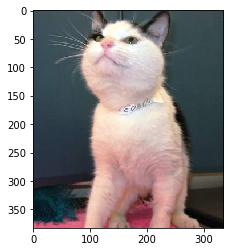

In [8]:
sample = random.choice(filenames)
image = load_img("./train/" + sample)
plt.imshow(image)

This is the original image. It will be resized during training.

## Building the Model
Now it's time to build our actual model. We will be creating a convolutional neural network. The first layer of the CNN will be an input layer to represent out image data and reshape it into a single-dimensional array. The second layer will be the convolutional layer that will extract the features from the image. The third layer will be a pooling layer to reduce the spatial volume of the input image. Next is a fully connected lyaer that will connect the network from one layer to another. The final layer is the output layer that will give us the prediction.

We will use ReLu for the activation function, as that is considered to be best practice according to [Machine Learning Mastery](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/). According to [Wikipedia](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), a rectifier function is an activation function where $f(x) = x^+ = \max{(0, x)}$, thus always returning either 0 or a positive number. ReLu is best because of its simple calculation (`max` function vs. calculating a exponent), its ability to return actual zero values (as opposed to other functions' mere approximations to zero), linear behavior, and its ability "to exploit improvements in hardware to train multi-layered networks with a nonlinear activation function using backpropagation."

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

# Input layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# pooling layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# fully connected layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

# output layer
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# results
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 198, 198, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 97, 97, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)      

## Callbacks
We want to add some optimizations to our model. We want to avoid our model overfitting the data, and we want to make sure accuracy is always improving.

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Early Stopping
If `val_loss` stops decreasing after 10 epochs, then we will stop learning to prevent overfitting.

In [11]:
early_stop = EarlyStopping(patience=10)

### Learning Rate Reduction
If accuracy does not increase for two steps, then we will reduce the learning rate.

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [13]:
callbacks = [early_stop, learning_rate_reduction]

## Preparing the Testing Data
It's now time to prepare the testing data. We're using an image generator with `class_mode="categorical"`, so we will need to convert the category column into a string. Then the image generator will convert that to one-hot encoding. So we will have the `1`'s converted to `dog`s and the `0`'s converted to `cat`s.

In [14]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

Let's check if this worked really quickly.

In [15]:
df.head()

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [16]:
df.tail()

,filename,category
24995,dog.9995.jpg,dog
24996,dog.9996.jpg,dog
24997,dog.9997.jpg,dog
24998,dog.9998.jpg,dog
24999,dog.9999.jpg,dog


Looks good so far. Now it's time to split the data.

In [17]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [18]:
train_df['category'].value_counts()

dog    10015
cat     9985
Name: category, dtype: int64

In [19]:
validate_df['category'].value_counts()

cat    2515
dog    2485
Name: category, dtype: int64

In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

## Generators
We will now create our data generators. We will have one for training and one for validation. These generators will apply various transformations to our images, "creating" more images to use for training and validation. This will allow us to have more data for training and validation without having to go out and download more images. It gets us more mileage out of our data set without having to worry about hardware space.

### Training Generator

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


### Evaluating the Generators

In [23]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


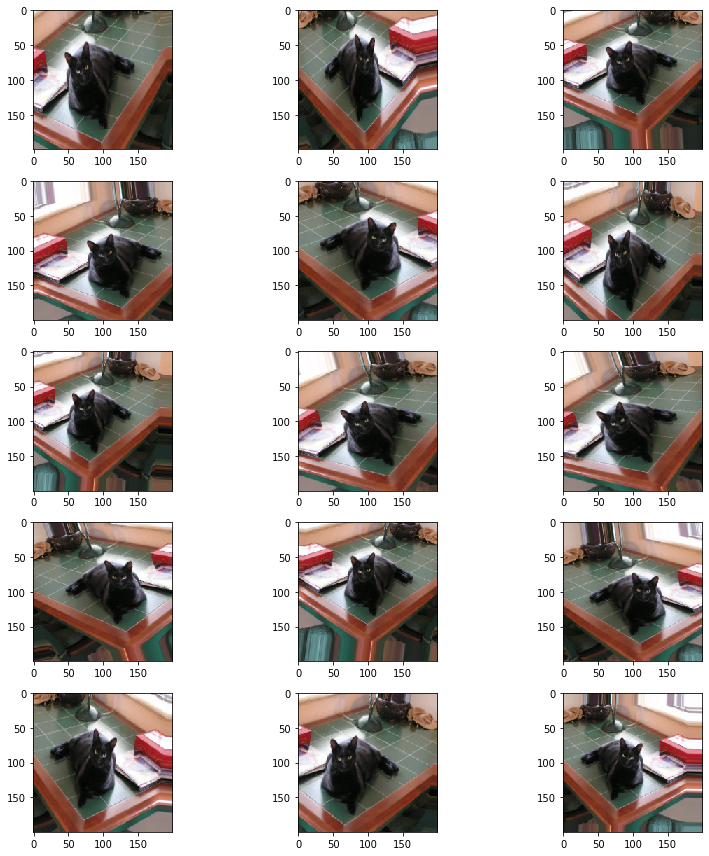

In [24]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

The model appears to be doing alright right now. We have quite a few transformations per image to help provide the training phase a lot of data to work with, and the detail on each image still seems to be good.

## Fitting the Model
Now it's time to actually fit the model we created. We will use 50 epochs for a thorough training.

In [27]:
epochs = 50
    
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1333/1333 [==============================] - 214s 161ms/step - loss: 0.2680 - accuracy: 0.8878 - val_loss: 0.2419 - val_accuracy: 0.9111
Epoch 2/50
1333/1333 [==============================] - 207s 156ms/step - loss: 0.2714 - accuracy: 0.8887 - val_loss: 0.0560 - val_accuracy: 0.9163
Epoch 3/50
1333/1333 [==============================] - 208s 156ms/step - loss: 0.2622 - accuracy: 0.8885 - val_loss: 0.0794 - val_accuracy: 0.9178
Epoch 4/50
1333/1333 [==============================] - 208s 156ms/step - loss: 0.2603 - accuracy: 0.8922 - val_loss: 0.1394 - val_accuracy: 0.9055
Epoch 5/50
1333/1333 [==============================] - 207s 155ms/step - loss: 0.2619 - accuracy: 0.8927 - val_loss: 0.1436 - val_accuracy: 0.9155

Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 6/50
1333/1333 [==============================] - 206s 155ms/step - loss: 0.2584 - accuracy: 0.8922 - val_loss: 0.1560 - val_accuracy: 0.9194
Epoch 7/50
1333/1333 [=========

Let's save this model and its weights for now.

In [28]:
model.save_weights("model_weights.h5")
model.save("model.h5")

## Evaluating Training
Let's see how this model did. We're going to plot the loss function and the accuracy for the training and validation generators.

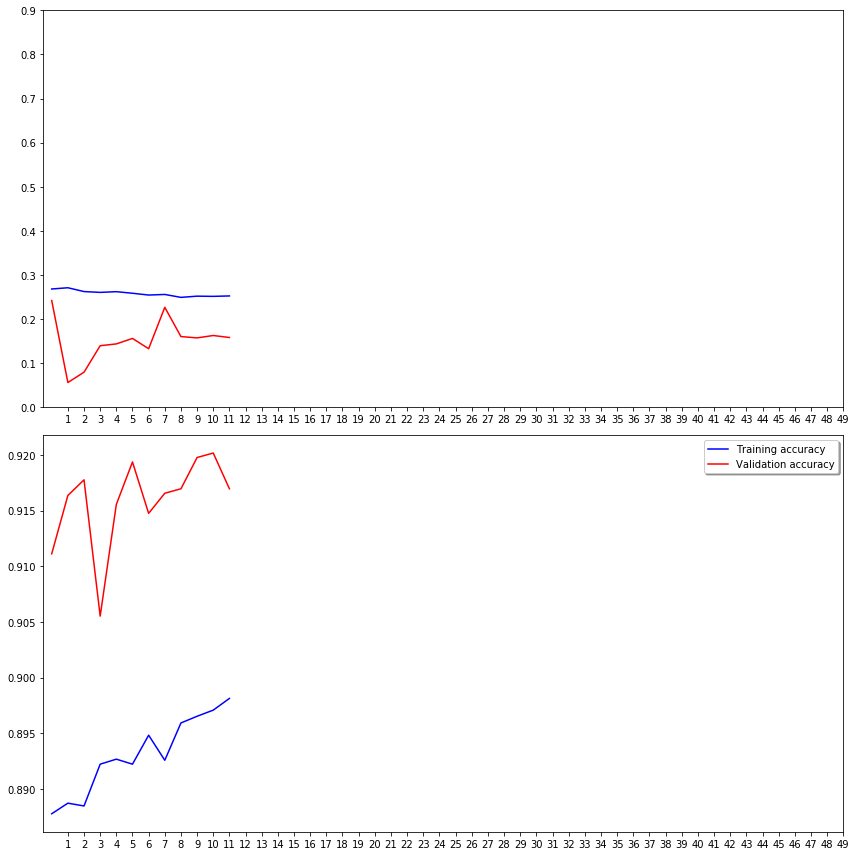

In [38]:
# plotting loss function
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

# plotting accuracy
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

While, for some reason, the model has problems running for the full 50 epochs when set to that mode, our model is pretty accurate for a first try. A training accuracy of ~89% is nothing to sneeze at. The validation accuracy is even better with being in the +90%, which means it will do well on new data; our model is not overfitting in this case.

## Testing
It's now time to test the model.

### Preparing Test Data

In [30]:
test_filenames = os.listdir("./test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

### Creating the Testing Generator

In [31]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


### Prediction

In [32]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

This will return the probabilities that an image belongs to each category. We want to select whatever category has the highest probability.

In [33]:
test_df['category'] = np.argmax(predict, axis=-1)

Next, we will convert the predicted category back into our generator classes by using `train_generator.class_indices`.

In [34]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

### Evaluation

In [35]:
test_df['category'].value_counts()

dog    6251
cat    6249
Name: category, dtype: int64

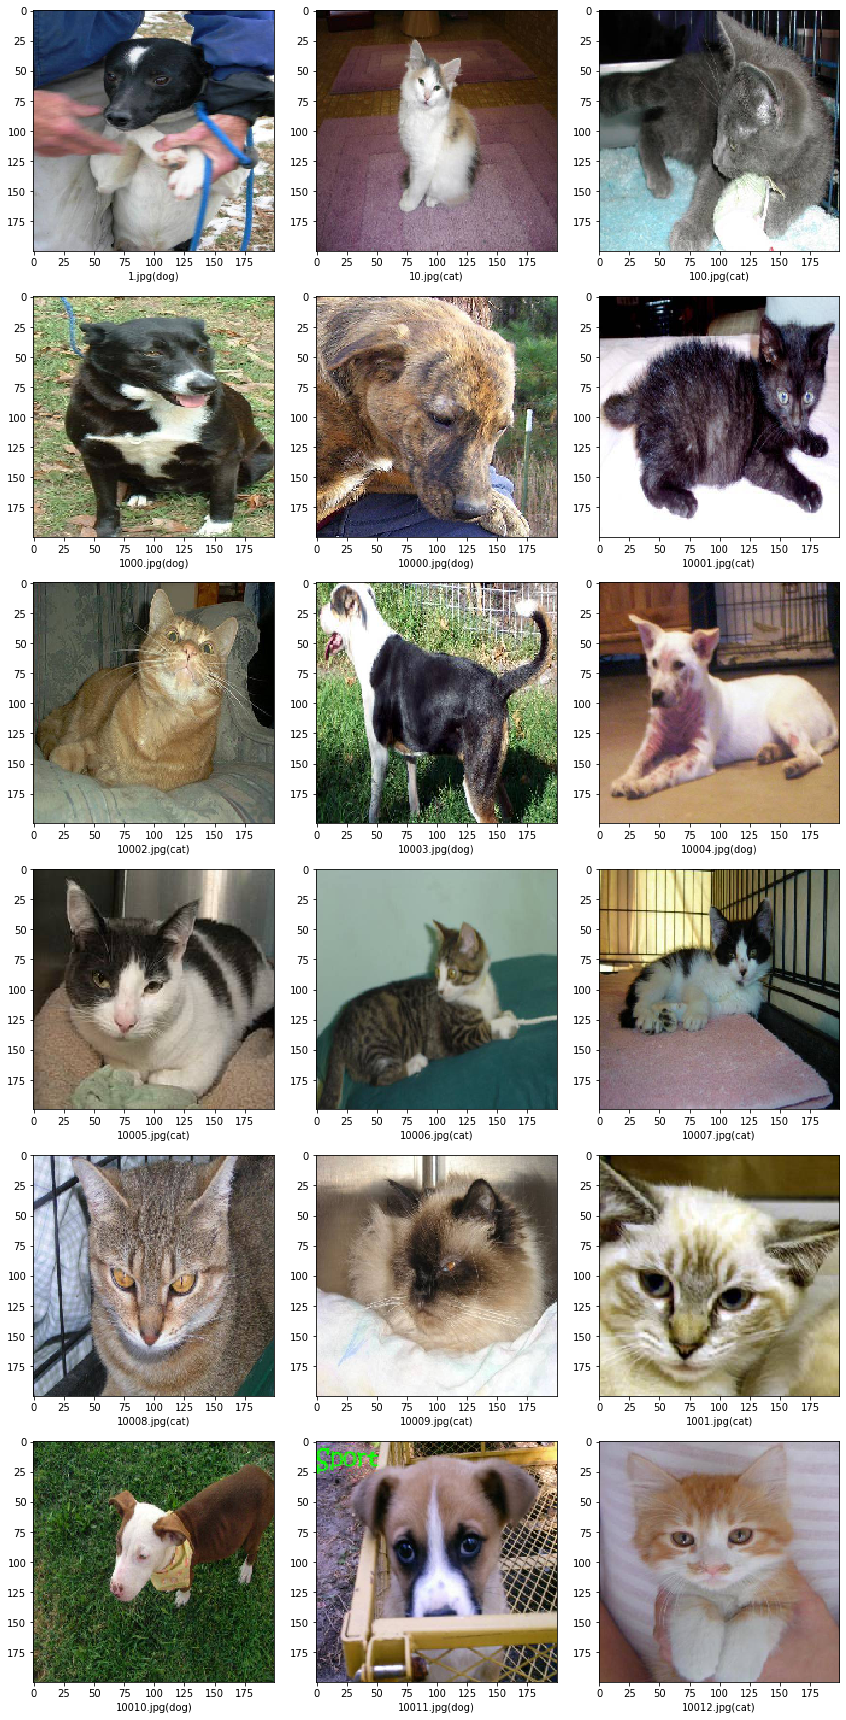

In [36]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

These results are pretty good.

## Conclusion
This is a satisfactory model. It has a high degree of accuracy without overfitting.

We can try a few things to improve the model. While ReLu is considered the best in most cases, we can see if other activation functions would do better to see if this is one of those few instances where ReLu isn't the best. Additionally, we could play with the pixel sizes. While I rejected 128x128 and 256x256 in my data exploration, we could try these and see how the model does. We could also see if using gray-scale images would improve the model despite my rejection of it. We could naturally change the number of epochs that the model runs for to see what else it can learn during training. We could test using other APIs like TensorFlow and see how they compare to Keras. We have plenty of options to test the model, but what we have now is a good start.